# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [19]:
# imports
import panel as pn
import plotly.express as px
import pandas as pd
pn.extension('plotly')
pn.extension(comms='vscode')
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

In [20]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("mapbox")
px.set_mapbox_access_token(map_box_api)

In [21]:
# Import the necessary CSVs to Pandas DataFrames
# Create path to location of file
file_path_loc = Path("./Data/neighborhoods_coordinates.csv")
# read file into dataframe
neighborhood_df = pd.read_csv(file_path_loc)
neighborhood_df.head()

,Neighborhood,Lat,Lon
0,Alamo Square,37.791012,-122.402100
1,Anza Vista,37.779598,-122.443451
2,Bayview,37.734670,-122.401060
3,Bayview Heights,37.728740,-122.410980
4,Bernal Heights,37.728630,-122.443050


- - -

In [22]:
# Create path to location of file
file_path_census = Path("Data/sfo_neighborhoods_census_data.csv")
# read file into dataframe
sfo_neigh_census_df = pd.read_csv(file_path_census)
sfo_neigh_census_df.head()


,year,neighborhood,sale_price_sqr_foot,housing_units,gross_rent
0,2010,Alamo Square,291.182945,372560,1239
1,2010,Anza Vista,267.932583,372560,1239
2,2010,Bayview,170.098665,372560,1239
3,2010,Buena Vista Park,347.394919,372560,1239
4,2010,Central Richmond,319.027623,372560,1239


## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [23]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    # prepare data - get housing units and mean
    housing_units_per_year = sfo_neigh_census_df[["housing_units","year"]].groupby("year").mean()
    #create figure and axes objects for the plot
    fig_hsing_year , ax_hse = plt.subplots()
    # create plot and get axes
    ax_hse = housing_units_per_year.plot(kind="bar",title="Housing Units in San Francisco from 2010 to 2016",ax=ax_hse)
    # calculate y limits
    housing_units_std = housing_units_per_year.std()
    housing_units_min = housing_units_per_year.min()
    housing_units_max = housing_units_per_year.max()
    min_val = housing_units_min - housing_units_std
    max_val = housing_units_max +  housing_units_std
    # set y limits
    ax_hse.set_ylim(ymin=min_val.values,ymax=max_val.values)
    # create and return pane object with plot
    return pn.pane.Matplotlib(fig_hsing_year, tight = True)
    

def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    
    # prepare data - get averages
    average_prices = sfo_neigh_census_df[["sale_price_sqr_foot","gross_rent","year"]].groupby(by="year").mean()
    #create figure and axes objects for the plot
    fig_avg_rent, ax_rent = plt.subplots()
    # create plot and get axes
    ax_rent = average_prices["gross_rent"].plot(kind="line",color="red")
    # preapare axes and title
    ax_rent.set(xlabel="Year",ylabel="Average Gross Rent",title="Average Gross Rent by Year")
    # create and return pane object with plot
    return  pn.pane.Matplotlib(fig_avg_rent, tight = True)



def average_sales_price():
    """Average Sales Price Per Year."""
    
    # prepare data - get averages
    average_sale_price = sfo_neigh_census_df[["sale_price_sqr_foot","gross_rent","year"]].groupby(["year"]).mean()
    #create figure and axes objects for the plot
    fig_avg_sales, ax_sales = plt.subplots()
    # create plot and get axes
    ax_sales = average_sale_price["sale_price_sqr_foot"].plot(kind="line",color="purple")
    # preapare axes and title
    ax_sales.set(xlabel="Year",ylabel="Price per Sqft",title="Average Sale Price Per SqFt by Year")
    # create and return pane object with plot
    return pn.pane.Matplotlib(fig_avg_sales, tight = True)
    



def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    
    # prepare data - neighborhood data
    sfo_group_neigh = sfo_neigh_census_df.groupby(["year","neighborhood"]).mean()
    sfo_group_neigh.reset_index(inplace=True)
    # create plot to show Average Sales Price per ft.
    sale_plot= sfo_group_neigh.hvplot(x="year",y="sale_price_sqr_foot",groupby="neighborhood",xlabel="Year",ylabel="Avg. Sale Price per Square Foot")
    # create a plot to show gross rent per year.
    rent_plot =sfo_group_neigh.hvplot(x="year",y="gross_rent",groupby="neighborhood",xlabel="Year",ylabel="Avg. Gross Rent per Year")
    # create a plot with above plots shwoing vertically 
    avg_price_plot = (sale_plot + rent_plot).cols(1)
    # return the hvplot
    return avg_price_plot
    




def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""

    # prepare data - neighborhood sales
    neighbor_mean_sale_price= sfo_neigh_census_df.groupby(by='neighborhood').mean()
    # get top expensive neighborhoods
    ten_expensive_neighborhoods = neighbor_mean_sale_price.nlargest(10, columns='sale_price_sqr_foot')
    # create a plot to show top expensive neighborhoods
    expensive_nei_plot = ten_expensive_neighborhoods['sale_price_sqr_foot'].hvplot.bar(rot=90, 
                                            yformatter="%0.0f", 
                                            label="Top 10 Expensive Neighborhoods in SF", 
                                            xlabel='Neighborhood', ylabel='Avg Price Per Sq Foot')
    # return the plot
    return expensive_nei_plot

def most_expensive_neighborhoods_rent_sales():
    """Comparison of Rent and Sales Prices of Most Expensive Neighborhoods."""   
    
   # prepare data - neighborhood sales
    neighbor_mean_sale_price= sfo_neigh_census_df.groupby(by='neighborhood').mean()
    # get top expensive neighborhoods
    ten_expensive_neighborhoods = neighbor_mean_sale_price.nlargest(10, columns='sale_price_sqr_foot')
    # create a plot to show comapre rent and sales of  expensive neighborhoods
    most_exp_plot= ten_expensive_neighborhoods.hvplot.bar(x="year",rot =90, y=["sale_price_sqr_foot","gross_rent"],groupby="neighborhood", xlabel="Year",ylabel="Price",yformatter="%0.0f")
    #return the plot
    return most_exp_plot
    
def parallel_coordinates():
    """Parallel Coordinates Plot."""

    # prepare data - expensive neighborhoods
    expensive_neighborhoods = sfo_neigh_census_df.groupby('neighborhood').mean().nlargest(10, 'sale_price_sqr_foot').reset_index()
    # create the plot 
    expensive_parr_plot = px.parallel_coordinates(expensive_neighborhoods,title="Parallel Coordinates of Most Expensive neighborhoods in San Francisco", color='sale_price_sqr_foot')
    #return the plot
    return expensive_parr_plot


def parallel_categories():
    
    """Parallel Categories Plot."""
    
    # prepare data - expensive neighborhoods
    expensive_neighborhoods = sfo_neigh_census_df.groupby('neighborhood').mean().nlargest(10, 'sale_price_sqr_foot').reset_index()
    # create the plot 
    expensive_pcat_plot = px.parallel_categories(
        expensive_neighborhoods,
        title="Parallel Categories of Most Expensive neighborhoods in San Francisco",
        dimensions=["neighborhood", "sale_price_sqr_foot", "housing_units", "gross_rent"],
        color="sale_price_sqr_foot",
        color_continuous_scale=px.colors.sequential.Inferno,
    )
      #return the plot
    return expensive_pcat_plot


def neighborhood_map():
    """Neighborhood Map."""

     # prepare data - neighborhood 
    neighborhood_mean = sfo_neigh_census_df.groupby('neighborhood').mean().reset_index()
    # concat with locaation information dataframe to get the geo location information
    neighborhood_mean_location = pd.concat([neighborhood_mean,neighborhood_df], axis='columns',join="inner").drop(columns=['Neighborhood'])
      # create the plot 
    neighborhood_map = px.scatter_mapbox(neighborhood_mean_location,
                                     lat="Lat",
                                     lon="Lon",
                                     mapbox_style ="carto-positron",
                                     color="gross_rent",
                                     size="sale_price_sqr_foot",
                                     title = "Average Sale Price per Sq.Foot and Gross Rent in San Francisco",
                                     color_continuous_scale=px.colors.cyclical.IceFire,
                                     size_max=12,
                                     zoom=10
                                    )
    # return the plot
    return neighborhood_map




def sunburst():
    """Sunburst Plot."""
    
    # YOUR CODE HERE!
    most_expensive_neighborhoods = sfo_neigh_census_df.groupby(by='neighborhood').mean()
    most_expensive_neighborhoods = most_expensive_neighborhoods.nlargest(10, columns='sale_price_sqr_foot')
    df_expensive_neighborhoods_per_year = sfo_neigh_census_df[sfo_neigh_census_df["neighborhood"].isin(most_expensive_neighborhoods.index)]
    df_expensive_neighborhoods_per_year.head()
    fig_sunburst = px.sunburst(
        df_expensive_neighborhoods_per_year,
        path=[df_expensive_neighborhoods_per_year.year, "neighborhood"],
        values='sale_price_sqr_foot',
        color='gross_rent', 
        color_continuous_scale='Blues',
        title="Costs Analysis of Most Expensive neighborhoods in San Francisco per Year",
        height=550
    )
    return fig_sunburst


## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

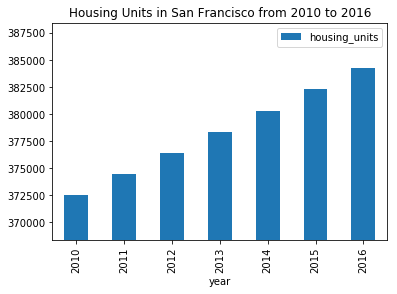

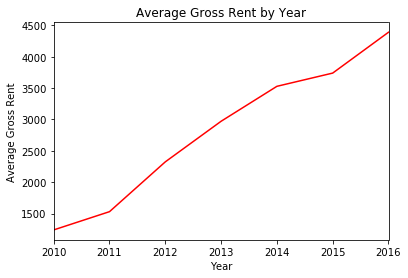

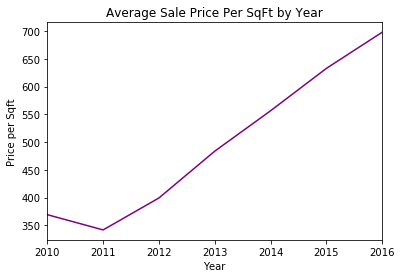

In [24]:
# Create a Title for the Dashboard
title = pn.pane.Markdown(
    """
# Real Estate Analysis of San Fransisco, CA from 2010 - 2016
    """,
    width = 960,
    sizing_mode = "scale_both"
)
description = pn.pane.Markdown(
    """
This dashboard provides a 7 year analysis of the housing sales and rental market in the San Francisco area from 2010 - 2016. 
You can navigate through the tabs to learn & explore the evolution of real estate in the city.
    """
)

# Create a tab layout for the dashboard
# YOUR CODE HERE!
tabs = pn.Tabs(
    ("Welcome", pn.Column(description, neighborhood_map())),
    ("Yearly Market Analysis", pn.Row(housing_units_per_year(), average_gross_rent(), average_sales_price(), scroll=True)),
    ("Neighborhood Analysis", pn.Column(average_price_by_neighborhood(), top_most_expensive_neighborhoods())),
    ("Parallel Plots Analysis", pn.Column(parallel_coordinates(), parallel_categories()),
    ),
    ("Sunburst Plot Analysis", pn.Column(sunburst()),
    ),
    sizing_mode = "scale_both"
)

## Create the dashboard
dashboard = pn.Column(pn.Row(title), tabs,  sizing_mode = "scale_both")

## Serve the Panel Dashboard

In [25]:
# Serve the# dashboard
dashboard.servable()

BokehModel(combine_events=True, render_bundle={'docs_json': {'bac2447f-95a0-487a-8068-4217f6d055c2': {'defs': …

Column(sizing_mode='scale_both')
    [0] Row
        [0] Markdown(str, sizing_mode='scale_both', width=960)
    [1] Tabs(sizing_mode='scale_both')
        [0] Column
            [0] Markdown(str)
            [1] Plotly(Figure)
        [1] Row(scroll=True)
            [0] Matplotlib(Figure, tight=True)
            [1] Matplotlib(Figure, tight=True)
            [2] Matplotlib(Figure, tight=True)
        [2] Column
            [0] Row
                [0] HoloViews(Layout)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                    [1] VSpacer()
            [1] HoloViews(Bars)
        [3] Column
            [0] Plotly(Figure)
            [1] Plotly(Figure)
        [4] Column
            [0] Plotly(Figure)

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

In [26]:
#housing_units_per_year()

In [27]:
#average_gross_rent()

In [28]:
# average_sales_price()

In [29]:
#average_price_by_neighborhood()

In [30]:
# top_most_expensive_neighborhoods()

In [31]:
# most_expensive_neighborhoods_rent_sales()

In [32]:
# neighborhood_map().show()

In [33]:
# parallel_categories()

In [34]:
# parallel_coordinates()

In [35]:
#sunburst()